<a href="https://colab.research.google.com/github/bortoliotavio/Desafio/blob/main/Desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importando bibliotecas
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
# Carregando os dados
file_path = '/content/drive/MyDrive/Colab Notebooks/Desafio/data.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Substituir espaços em branco por NaN
df = df.replace('', pd.NA)

# Contar valores nulos em cada coluna (incluindo os espaços em branco)
nulos_por_coluna = df.isna().sum()
print("Contagem de valores nulos ou em branco por coluna:")
print(nulos_por_coluna)
# Contar valores negativos em cada coluna, apenas colunas de valor numerico
negativos_por_coluna = (df.select_dtypes(include=['number']) < 0).sum()
print("\nContagem de valores negativos por coluna:")
print(negativos_por_coluna)

# Especificaçao para limpeza descritiva, foi feito filtro para que pudesse ser ignorado possiveis caracteres em descriçoes.
regex_padrao_estranho = r'[^\w\s\/\-\'\.\+&\,\""\!\(\£\)\*]'

# Mantendo os que nao forem considerados padrões estranhos
df_limpo = df[~df['Description'].str.contains(regex_padrao_estranho, na=False, regex=True)]

# Apos a limpeza
print("\nDataFrame após a limpeza:")
print(df_limpo.head())

Contagem de valores nulos ou em branco por coluna:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Contagem de valores negativos por coluna:
Quantity      10624
UnitPrice         2
CustomerID        0
dtype: int64

DataFrame após a limpeza:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1

In [ ]:
# Feito uma copia para redundancia
df_limpo = df_limpo.copy()

# Converter 'InvoiceDate' para datetime
df_limpo['InvoiceDate'] = pd.to_datetime(df_limpo['InvoiceDate'])

# Limpeza de Dados
# Removida descrições ausentes
dado_tratado = df_limpo.dropna(subset=['Description'])

# Removida 'CustomerID' que é ausente
dado_tratado = dado_tratado.dropna(subset=['CustomerID'])

# Remover 'UnitPrice' é negativo ou zero
dado_tratado = dado_tratado[dado_tratado['UnitPrice'] > 0]

# Remover 'Quantity' é negativo ou zero
dado_tratado = dado_tratado[dado_tratado['Quantity'] > 0]


 Grafico antes do limite de percentil: 



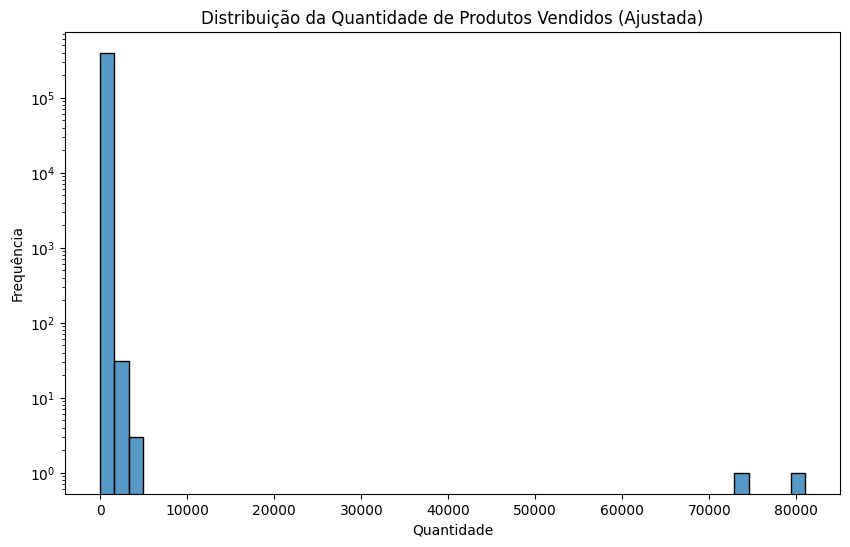


 Grafico apos o limite de percentil: 



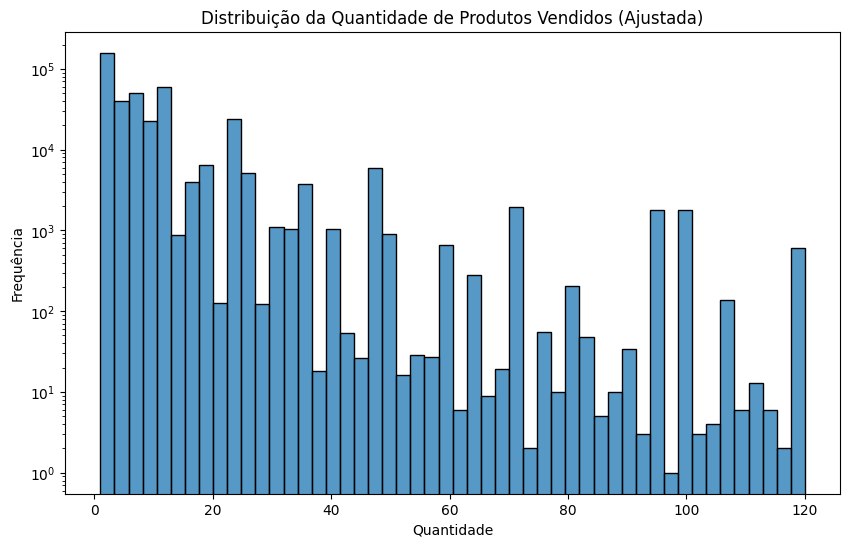

In [ ]:
# Análise Exploratória de Dados
# Visualização 1: Histograma de Quantidades

print('\n Grafico antes do limite de percentil: \n')
plt.figure(figsize=(10, 6))
sns.histplot(dado_tratado['Quantity'], bins=50, kde=False)
plt.title('Distribuição da Quantidade de Produtos Vendidos (Ajustada)')
plt.xlabel('Quantidade')
plt.ylabel('Frequência')
plt.yscale('log')
plt.show()


# Aplicar o limite do percentil 99 para 'Quantity'
quantile_99 = dado_tratado['Quantity'].quantile(0.99)
dado_tratado = dado_tratado[dado_tratado['Quantity'] <= quantile_99]

print('\n Grafico apos o limite de percentil: \n')

plt.figure(figsize=(10, 6))
sns.histplot(dado_tratado['Quantity'], bins=50, kde=False)
plt.title('Distribuição da Quantidade de Produtos Vendidos (Ajustada)')
plt.xlabel('Quantidade')
plt.ylabel('Frequência')
plt.yscale('log')
plt.show()

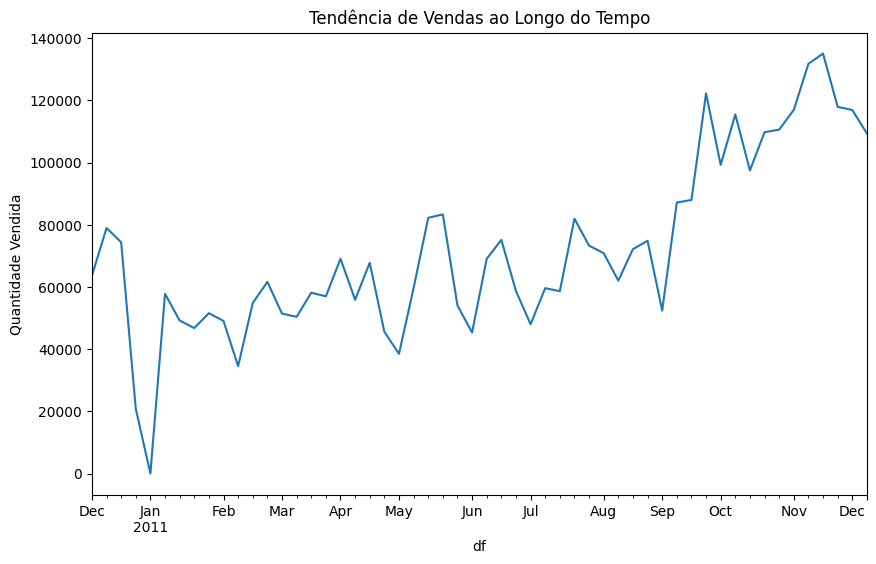

In [ ]:
# Visualização 2: Vendas ao Longo do Tempo
dado_tratado.set_index('InvoiceDate')['Quantity'].resample('W').sum().plot(figsize=(10, 6))
plt.title('Tendência de Vendas ao Longo do Tempo')
plt.xlabel('df')
plt.ylabel('Quantidade Vendida')
plt.show()

In [ ]:
# Configurando o ambiente do SQLite para consultas SQL
conn = sqlite3.connect(':memory:')
dado_tratado.to_sql('df', conn, index=False, if_exists='replace')

393994

In [ ]:

# Consulta 1: Top 10 Vendas Totais por País
query1 = """
SELECT Country, COUNT(*) as TotalOrders,
       ROUND(SUM(CAST(Quantity AS REAL)), 2) as TotalQuantity,
       ROUND(SUM(CAST(Quantity AS REAL) * CAST(UnitPrice AS REAL)), 2) as TotalSales
FROM df
GROUP BY Country
ORDER BY TotalSales DESC
LIMIT 10
"""
sales_by_country = pd.read_sql(query1, conn)

# Formatação dos valores
sales_by_country['TotalQuantity'] = sales_by_country['TotalQuantity'].map('{:,.2f}'.format)
sales_by_country['TotalSales'] = sales_by_country['TotalSales'].map('${:,.2f}'.format)

print(sales_by_country)

          Country  TotalOrders TotalQuantity     TotalSales
0  United Kingdom       351569  3,228,883.00  $5,915,202.29
1         Germany         8999    111,912.00    $223,452.36
2            EIRE         7055    101,309.00    $212,095.20
3          France         8312    104,645.00    $200,649.59
4     Netherlands         1876     93,175.00    $166,064.92
5       Australia          968     34,769.00     $79,580.67
6     Switzerland         1838     29,506.00     $56,157.39
7           Spain         2465     23,770.00     $50,859.09
8         Belgium         2028     22,641.00     $40,992.66
9          Norway         1065     18,184.00     $35,646.08


In [ ]:
# Verificar os tipos de dados no SQLite
query_check_types = """
SELECT typeof(Quantity) AS QuantityType, typeof(UnitPrice) AS UnitPriceType FROM df LIMIT 1
"""
types_df = pd.read_sql(query_check_types, conn)
types_df['QuantityType'] = types_df['QuantityType'].str.upper()  # Converter para maiúsculas
types_df['UnitPriceType'] = types_df['UnitPriceType'].str.upper()  # Converter para maiúsculas

# Imprimir os tipos de dados formatados
print(f"{'QuantityType':<15} {'UnitPriceType':<15}")
print(f"{types_df['QuantityType'].iloc[0]:<15} {types_df['UnitPriceType'].iloc[0]:<15}\n")

# Testar a operação aritmética com alguns valores
query_test_arithmetic = """
SELECT Description, Quantity, UnitPrice, Quantity * UnitPrice AS Total FROM df LIMIT 10
"""
arithmetic_df = pd.read_sql(query_test_arithmetic, conn)

# Formatar a saída da operação aritmética
arithmetic_df['Total'] = arithmetic_df['Total'].apply(lambda x: f"${x:.2f}")

# Imprimir os resultados da operação aritmética formatados
print(arithmetic_df.to_string(index=False) + "\n")

# Comparar totais do pandas DataFrame e do banco de dados SQLite
# Corrigindo o cálculo do total de vendas no pandas
total_sales_pandas = (dado_tratado['Quantity'] * dado_tratado['UnitPrice']).sum()
print(f"Total de vendas no pandas: {total_sales_pandas}\n")

query_total_sales_sqlite = """
SELECT SUM(Quantity * UnitPrice) AS TotalSales FROM df
"""
total_sales_sqlite = pd.read_sql(query_total_sales_sqlite, conn).iloc[0]['TotalSales']
print(f"Total de vendas no SQLite: {total_sales_sqlite}\n")

# Para o DataFrame do Pandas
# Supondo que seu DataFrame seja 'dado_tratado'
total_Quantity_pandas = (dado_tratado['Quantity']).groupby(dado_tratado['Country']).sum()
top_5_countries_pandas = total_Quantity_pandas.sort_values(ascending=False).head(5)
print("Top 5 países no pandas:")
print(top_5_countries_pandas.to_string() + "\n")

# Para o SQLite
query_top_5_countries_sqlite = """
SELECT Country, SUM(Quantity) AS Quantity
FROM df
GROUP BY Country
ORDER BY Quantity DESC
LIMIT 5
"""
top_5_countries_sqlite = pd.read_sql(query_top_5_countries_sqlite, conn)
print("Top 5 países no SQLite:")
print(top_5_countries_sqlite.to_string(index=False) + "\n")


QuantityType    UnitPriceType  
INTEGER         REAL           

                        Description  Quantity  UnitPrice  Total
 WHITE HANGING HEART T-LIGHT HOLDER         6       2.55 $15.30
                WHITE METAL LANTERN         6       3.39 $20.34
     CREAM CUPID HEARTS COAT HANGER         8       2.75 $22.00
KNITTED UNION FLAG HOT WATER BOTTLE         6       3.39 $20.34
     RED WOOLLY HOTTIE WHITE HEART.         6       3.39 $20.34
       SET 7 BABUSHKA NESTING BOXES         2       7.65 $15.30
  GLASS STAR FROSTED T-LIGHT HOLDER         6       4.25 $25.50
             HAND WARMER UNION JACK         6       1.85 $11.10
          HAND WARMER RED POLKA DOT         6       1.85 $11.10
      ASSORTED COLOUR BIRD ORNAMENT        32       1.69 $54.08

Total de vendas no pandas: 7220297.833999997

Total de vendas no SQLite: 7220297.834003142

Top 5 países no pandas:
Country
United Kingdom    3228883
Germany            111912
France             104645
EIRE               101309
Ne

In [ ]:
# Consulta 2: Top 10 Produtos Mais Vendidos
query2 = """
SELECT Description, SUM(Quantity) as TotalQuantity
FROM df
GROUP BY Description
ORDER BY TotalQuantity DESC
LIMIT 10
"""
top_products = pd.read_sql(query2, conn)
print(top_products)



                          Description  TotalQuantity
0             JUMBO BAG RED RETROSPOT          29971
1  WHITE HANGING HEART T-LIGHT HOLDER          23417
2     PACK OF 72 RETROSPOT CAKE CASES          22893
3       ASSORTED COLOUR BIRD ORNAMENT          22154
4   WORLD WAR 2 GLIDERS ASSTD DESIGNS          21535
5     VICTORIAN GLASS HANGING T-LIGHT          17243
6             LUNCH BAG RED RETROSPOT          16947
7                      POPCORN HOLDER          15139
8                  RABBIT NIGHT LIGHT          14230
9             JUMBO BAG PINK POLKADOT          13765


In [ ]:
conn.close()